In [1]:
from src.scraping.get_data import *
from src.utils.checks import *
from src.portfolio.data_manipulation import *
from src.plots.basics import *
from src.computations.compute_returns import *
from src.computations.metrics import *

get_data_info()
data = get_data_updated_2025()

In [2]:
download_data_updated()

File downloaded and renamed to MSCI_World.csv
File downloaded and renamed to MSCI_Europe_Small_Cap_Value_Weighted.csv
File downloaded and renamed to MSCI_Europe.csv
File downloaded and renamed to MSCI_ACWI.csv
File downloaded and renamed to S&P_500_Minimum_Volatility.csv
File downloaded and renamed to MSCI_Emerging_Markets.csv
File downloaded and renamed to FTSE_World_Government_Bond_Developed_Markets.csv
File downloaded and renamed to S&P_500.csv
File downloaded and renamed to MSCI_USA_Small_Cap_Value_Weighted.csv
File downloaded and renamed to MSCI_World_Momentum.csv


In [2]:
def merge_results(final_results, results):

    if final_results is None:
        return results
    else:
        merged_df = pd.merge(final_results, results, on="Date", how="outer")
        merged_df = merged_df.sort_values(by="Date").reset_index(drop=True)

        # Convert the 'Date' column to datetime (assuming MM/YYYY format)
        merged_df["Date"] = pd.to_datetime(merged_df["Date"], format="%m/%Y")

        # Sort by the datetime values
        merged_df = merged_df.sort_values(by="Date").reset_index(drop=True)

        # (Optional) Convert Date back to MM/YYYY string format if needed
        merged_df["Date"] = merged_df["Date"].dt.strftime("%m/%Y")

        return merged_df

In [3]:
get_list_of_portfolios()

['80_20_ACWI', '80_20_World', '80_20_2factors', '80_20_1factor', '60_40_World']

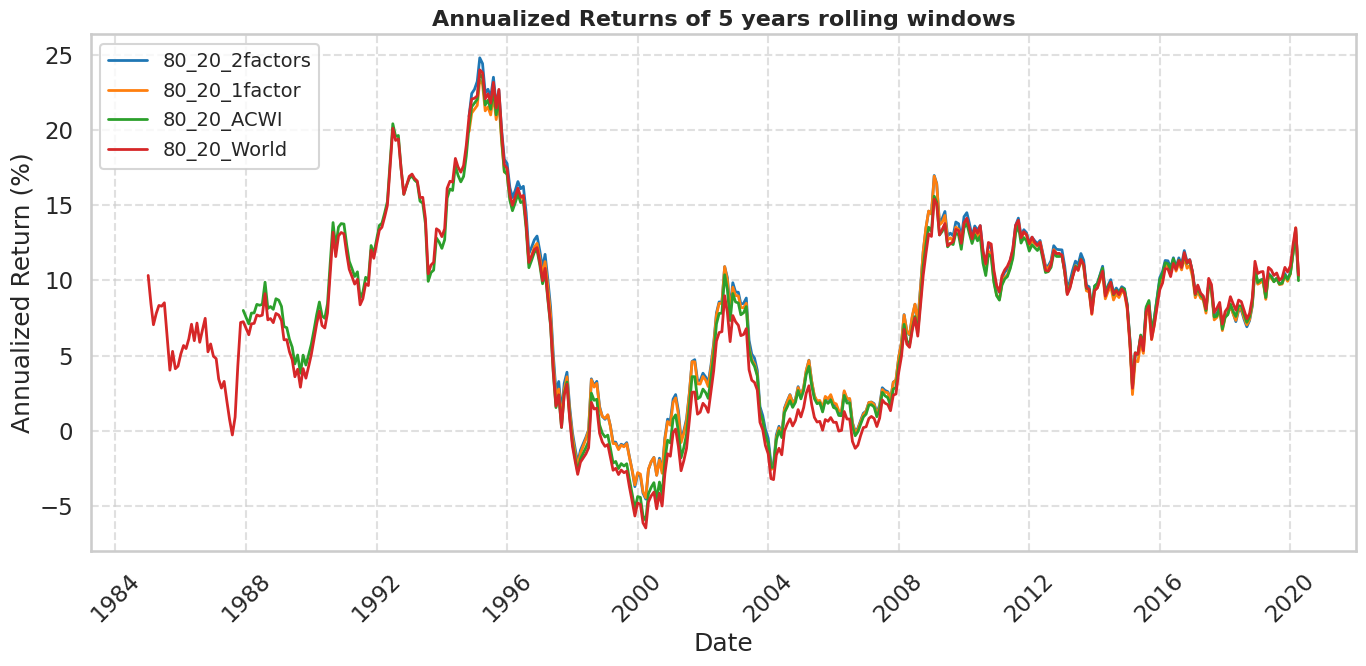

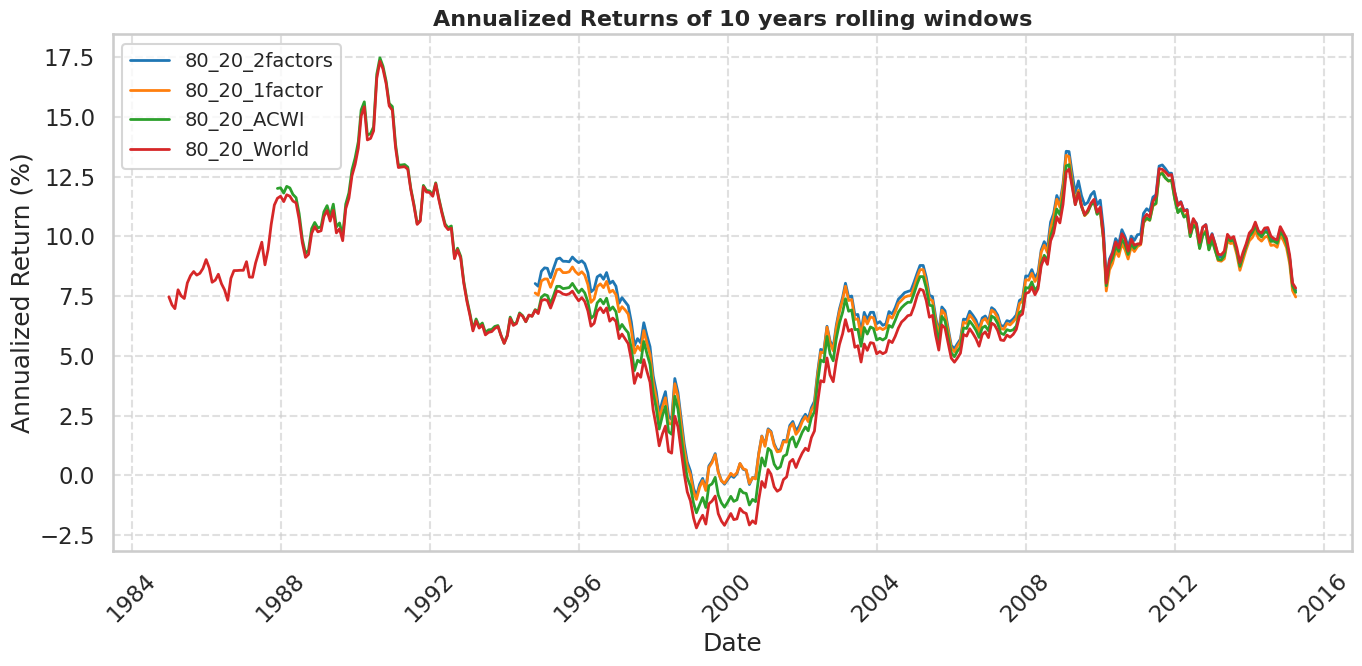

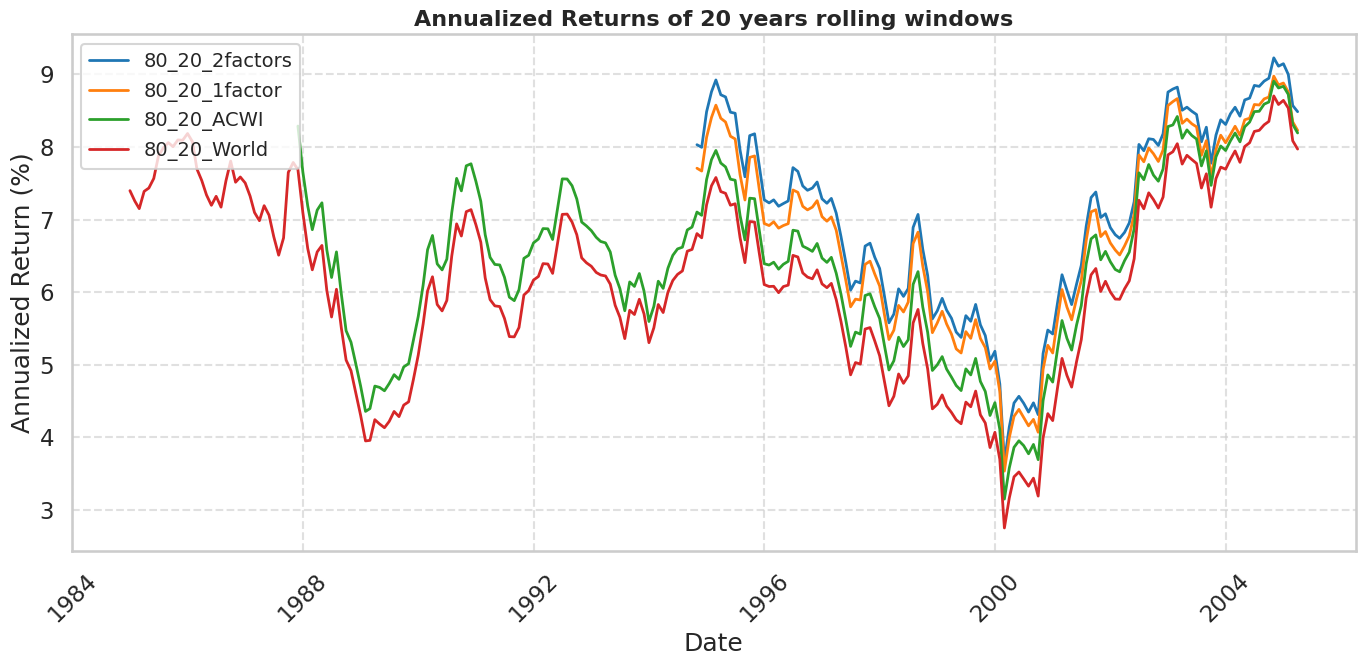

In [4]:
portfolios = ['80_20_2factors',
              '80_20_1factor',
              '80_20_ACWI',
              '80_20_World']

for years in [5, 10, 20]:
    final_results = None 
    for portfolio_name in portfolios:

        portfolio = load_portfolio(portfolio_name)
        data, weights = prune_data_portfolio(portfolio)

        # Compute the returns
        results = compute_portfolio_returns_combined(*prune_data_portfolio(portfolio), years=years)
        results = results.rename(columns={results.columns[-1]: portfolio_name})
        results[portfolio_name] = results[portfolio_name].round(5)

        final_results = merge_results(final_results, results)
    
    plot_annualized_returns(final_results, years=years)

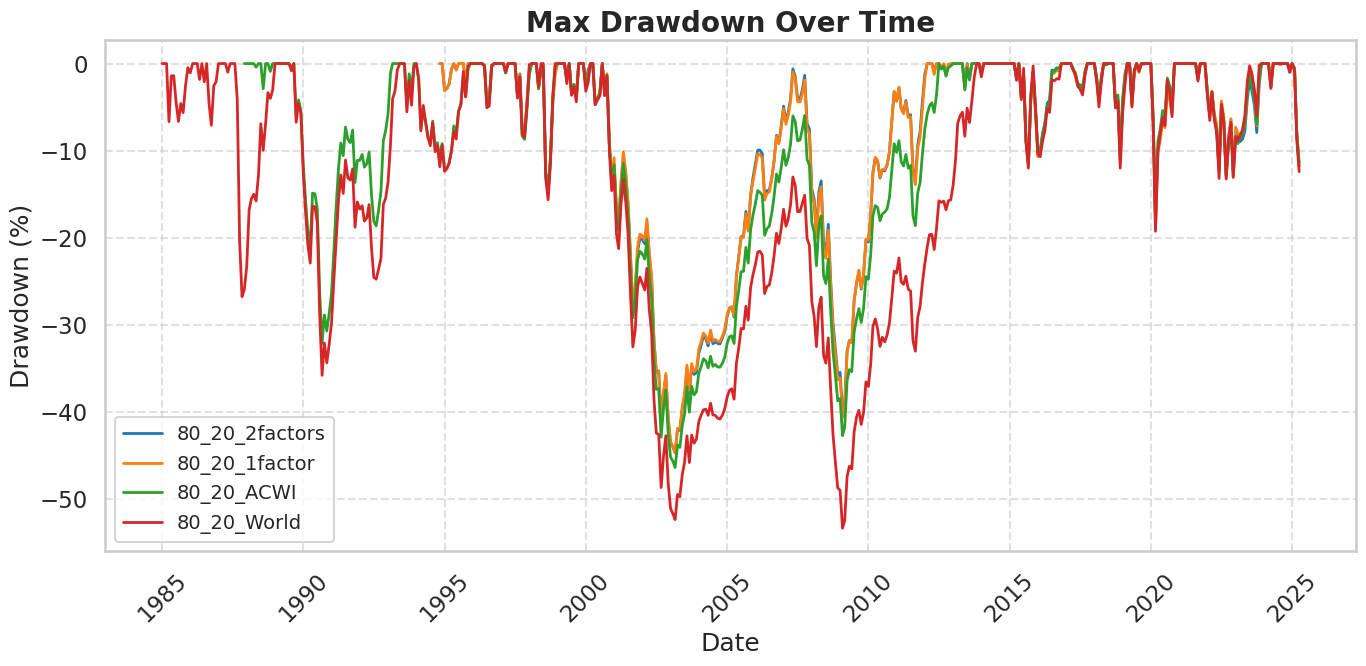

In [41]:
final_maxdrawdown = None

for portfolio_name in portfolios:

    portfolio = load_portfolio(portfolio_name)
    data, weights = prune_data_portfolio(portfolio)

    prices = compute_portfolio_prices(portfolio, portfolio_name)

    maxdrawdown = max_drawdown(prices)

    final_maxdrawdown = merge_results(final_maxdrawdown, maxdrawdown)

plot_max_drawdown(final_maxdrawdown)